In [1]:
!pip3 install tensorflow_text>=2.0.0rc0

In [ ]:
!pip install transformers sentencepiece

In [3]:
from transformers import AutoTokenizer, AutoModel
import pandas as pd
from collections import Counter
import time
import torch

In [33]:
df_no_bal = pd.read_excel('/content/drive/MyDrive/cw_classifier/Test_data_marked.xlsx')

In [34]:
df_no_bal

,Общая оценка,Цена/качество,Расположение,Качество сна,Номера,Чистота,Обслуживание,Текст отзыва
0,5,5.0,5,NaN,5,5.0,5,Элегантный отель в самом центре Дубай. Красивы...
1,5,5.0,5,5.0,5,5.0,5,Если стиль вашей поездки в Дубай-- это шоппинг...
2,5,5.0,5,5.0,5,5.0,5,Провели с супругой там уик енд. Брали самый лю...
3,5,4.0,5,5.0,5,5.0,5,"По дороге домой для того, чтобы перекантоватьс..."
4,4,3.0,2,4.0,4,4.0,4,"меня впечатлили размеры! самый огромный номер,..."
...,...,...,...,...,...,...,...,...
6871,5,4.0,4,5.0,5,4.0,5,"Для нас было плюсом, что в этом отеле можно ос..."
6872,5,5.0,4,5.0,5,5.0,5,Очень понравился отель.Хорошие номера с кухней...
6873,5,5.0,4,5.0,5,5.0,4,"В Петербурге бываю очень часто, поэтому появле..."
6874,5,5.0,5,5.0,5,5.0,5,Изумительное место! Я просто не ожидала такого...


<Axes: >

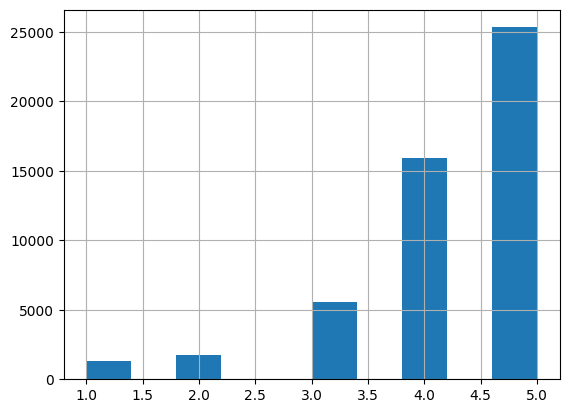

In [7]:
df_no_bal['Unnamed: 0'].hist()

In [8]:
Counter(df_no_bal['Unnamed: 0'])

Counter({4: 15930, 1: 1300, 5: 25331, 3: 5566, 2: 1775})

In [39]:
df_no_bal.drop(['Цена/качество', 'Качество сна', 'Номера', 'Расположение', 'Чистота', 'Обслуживание'], axis=1, inplace=True)
df_no_bal.rename(columns={'Общая оценка': 'rating', 'Текст отзыва': 'review'}, inplace=True)
grouped_df = df_no_bal.groupby('rating')
dfs_by_rating = [grouped_df.get_group(x) for x in grouped_df.groups]
min_count = 270
dfs_sampled = []
for d in dfs_by_rating:
  if len(d) >= min_count:
    dfs_sampled.append(d.sample(min_count, random_state=42))
  else:
    dfs_sampled.append(d.sample(len(d), random_state=42))
df_low2 = pd.concat(dfs_sampled)

In [40]:
df_low2

,rating,review
6241,1,Плохое лобби - первый раз в жизни пришлось сто...
3335,1,Останавливались на 4 дня. Завтрак однообразный...
6611,1,В Петербург прилетели семьей на весенние каник...
1633,1,Персонал ужасный и грубый!Отель ужасный!!!!!!я...
5536,1,Никаких 4 звезд. Максимум 2. Мне дали номер у ...
...,...,...
5161,5,Очень приятный отель на Владимирском проспекте...
507,5,"Очень понравилось! Все очень чисто, уборка каж..."
6391,5,Я останавливалась в этой гостинице раз 5 или 6...
4030,5,Останавливалась в этой гостинице пару раз. Что...


<Axes: >

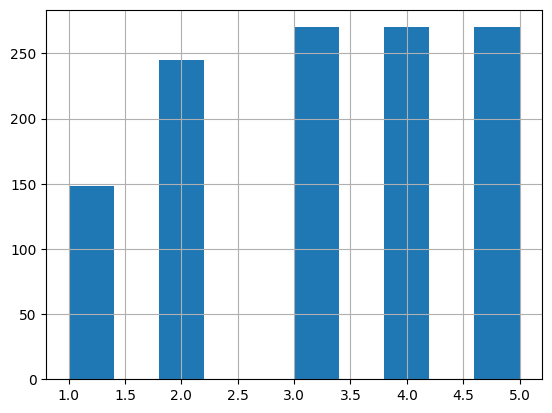

In [41]:
df_low2['rating'].hist()

In [42]:
df_low2 = df_low2.dropna()

In [23]:
Counter(df_low2['rating'])

Counter({1: 1295, 2: 1766, 3: 3987, 4: 3985, 5: 3985})

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("cointegrated/LaBSE-en-ru")
model = AutoModel.from_pretrained("cointegrated/LaBSE-en-ru")

In [44]:
sentences = df_low2['review'].to_list()
total_embed = []
start_time = time.time()
for i in range(0, len(sentences), 200):
  if i % 100 == 0:
    print('i =', i, '\ntime:', time.time() - start_time, '\n')
  if i+200 > len(sentences):
    encoded_input = tokenizer(sentences[i:], padding=True, truncation=True, max_length=64, return_tensors='pt')
  else:
    encoded_input = tokenizer(sentences[i:i+200], padding=True, truncation=True, max_length=64, return_tensors='pt')
  with torch.no_grad():
    model_output = model(**encoded_input)
  embeddings = model_output.pooler_output
  embeddings = torch.nn.functional.normalize(embeddings)
  total_embed += embeddings.tolist()
df_low2['LaBASE'] = total_embed

i = 0 
time: 0.00028777122497558594 

i = 200 
time: 66.97438526153564 

i = 400 
time: 116.07697010040283 

i = 600 
time: 164.02556777000427 

i = 800 
time: 212.77179050445557 

i = 1000 
time: 261.0636782646179 

i = 1200 
time: 309.0070102214813 



In [45]:
df_low2.to_csv('test_ru_LaBASE.csv')

In [ ]:
df_low2

In [46]:
tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")
model = AutoModel.from_pretrained("cointegrated/rubert-tiny2")

Some weights of the model checkpoint at cointegrated/rubert-tiny2 were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [47]:
df_low1 = pd.concat(dfs_sampled)
df_low1 = df_low1.dropna()

In [ ]:
df_low1

In [30]:
def embed_bert_cls(text, model, tokenizer):
    t = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
    with torch.no_grad():
        model_output = model(**{k: v.to(model.device) for k, v in t.items()})
    embeddings = model_output.last_hidden_state[:, 0, :]
    embeddings = torch.nn.functional.normalize(embeddings)
    return embeddings[0].cpu().numpy()

In [48]:
df_low1['bert'] = df_low1['review'].apply(lambda x: embed_bert_cls(x, model, tokenizer))

In [49]:
df_low1.to_csv('ru_bert.csv')